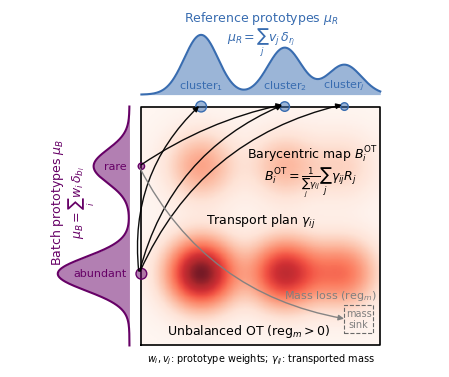

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

# mpl.rcParams["pdf.fonttype"] = 42   # TrueType (editable in Illustrator)
# mpl.rcParams["ps.fonttype"]  = 42
# mpl.rcParams["svg.fonttype"] = "none"  # keep text as real text in SVG

# ============ paste-and-run: scbiot_unbalanced_ot_schematic_3peaks_colors.py ============

def make_scbiot_unbalanced_ot_schematic():
    """
    Schematic for scBIOT's *unbalanced* prototype-based OT:

    - Left ribbon (μ_B, batch prototypes B_i): one abundant, one rare
        μ_B = ∑_i w_i δ_{b_i}
    - Top ribbon (μ_R, reference prototypes R_j): three modes / peaks
        μ_R = ∑_j v_j δ_{r_j}
    - Central heatmap: unbalanced OT plan γ(B_i, R_j) (2×3 coupling).
    - Mass sink in the transport plan: rare prototype can lose mass (reg_m).
    - Barycentric map:
        B_i^{OT} = (1 / ∑_j γ_{ij}) ∑_j γ_{ij} R_j
    """

    # custom colors
    color_ref = "#386cb0"   # reference side
    color_batch = "#660066" # batch side

    # gradient colormap from batch -> reference
    cmap_br = LinearSegmentedColormap.from_list(
        "batch_to_ref",
        [color_batch, color_ref]
    )

    fig, ax = plt.subplots(figsize=(4.6, 4.4))
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # ---- 0. Prototype positions and "mass" weights ----
    # Two batch prototypes (left)
    y_src = np.array([0.3, 0.75])              # positions along left: B_i
    w_src = np.array([1.0, 0.35])              # abundant vs rare

    # Three reference prototypes (top)
    x_tgt = np.array([0.25, 0.60, 0.85])       # positions along top: R_j
    w_tgt = np.array([0.7, 0.55, 0.35])        # three target modes

    # ---- 1. OT "weight field" γ(B_i, R_j) in the central square ----
    xx, yy = np.meshgrid(
        np.linspace(0, 1, 200),
        np.linspace(0, 1, 200),
    )

    # stylized 2x3 intensity: sum_i sum_j w_src[i]*w_tgt[j]*exp(-|| (x,y) - (xt,ys) ||^2 )
    intensity = np.zeros_like(xx)
    for ys, ws in zip(y_src, w_src):
        for xt, wt in zip(x_tgt, w_tgt):
            intensity += ws * wt * np.exp(-((xx - xt) ** 2 + (yy - ys) ** 2) / 0.02)
    intensity /= intensity.max() + 1e-8

    ax.imshow(
        intensity,
        extent=[0, 1, 0, 1],
        origin="lower",
        cmap='Reds',
        alpha=0.9,
        zorder=0,
    )

    # outline the transport square
    ax.plot(
        [0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0],
        color="black",
        linewidth=1.2,
        zorder=3,
    )

    # label for unbalanced OT
    ax.text(
        0.45,
        0.06,
        r"Unbalanced OT (reg$_m > 0$)",
        fontsize=9,
        ha="center",
        va="center",
        color="black",
        zorder=4,
    )

    # central label: transport plan γ
    ax.text(
        0.5,
        0.52,
        r"Transport plan $\gamma_{ij}$",
        fontsize=9,
        color="black",
        ha="center",
        va="center",
        zorder=4,
    )

    # ---- 2. Top ribbon: reference prototypes (3 peaks aligned to x_tgt) ----
    x = np.linspace(0, 1, 500)
    dens_top = np.zeros_like(x)
    for m, wt in zip(x_tgt, w_tgt):
        dens_top += wt * np.exp(-((x - m) ** 2) / 0.01)

    y_base_top = 1.05
    y_top_curve = y_base_top + 0.25 * dens_top / (dens_top.max() + 1e-8)

    ax.fill_between(
        x,
        y_base_top,
        y_top_curve,
        color=color_ref,
        alpha=0.5,
        linewidth=0,
        zorder=1,
    )
    ax.plot(
        x,
        y_top_curve,
        color=color_ref,
        linewidth=1.5,
        zorder=2,
    )
    ax.text(
        0.5,
        1.37,
        r"Reference prototypes $\mu_R$",
        ha="center",
        va="center",
        fontsize=9,
        color=color_ref,
    )

    # formula for μ_R = ∑_j v_j δ_{r_j}
    ax.text(
        0.5,
        1.27,
        r"$\mu_R = \sum_{j} v_j \,\delta_{r_j}$",
        ha="center",
        va="center",
        fontsize=9,
        color=color_ref,
    )

    # ---- 3. Left ribbon: batch prototypes (abundant + rare) ----
    # ---- 3. Left ribbon: batch prototypes (abundant + rare) ----
    y = np.linspace(0, 1, 500)

    # separate bumps for abundant and rare peaks
    sigma_left = 0.01
    dens_abund = np.exp(-((y - y_src[0]) ** 2) / sigma_left)
    dens_rare  = np.exp(-((y - y_src[1]) ** 2) / sigma_left)

    x_base_left = -0.05
    amp_abund = 0.3   # keep abundant peak amplitude unchanged
    amp_rare  = 0.15   # slightly larger width only for the rare peak

    # profile controls how far the ribbon extends to the left
    profile = amp_abund * dens_abund + amp_rare * dens_rare
    x_left_curve = x_base_left - profile

    ax.fill_betweenx(
        y,
        x_left_curve,
        x_base_left,
        color=color_batch,
        alpha=0.5,
        linewidth=0,
        zorder=1,
    )
    ax.plot(
        x_left_curve,
        y,
        color=color_batch,
        linewidth=1.5,
        zorder=2,
    )


    # cleaner labels for μ_B and its formula
    ax.text(
        -0.35,
        0.6,
        r"Batch prototypes $\mu_B$",
        ha="center",
        va="center",
        rotation=90,
        fontsize=9,
        color=color_batch,
    )

    # formula for μ_B = ∑_i w_i δ_{b_i}
    ax.text(
        -0.25,
        0.6,
        r"$\mu_B = \sum_{i} w_i \,\delta_{b_i}$",
        ha="center",
        va="center",
        rotation=90,
        fontsize=9,
        color=color_batch,
    )

    # ---- 4. Prototype dots on left (B_i) and top (R_j) ----
    # left: two prototypes, sized by w_src
    ax.scatter(
        np.zeros_like(y_src),
        y_src,
        s=60 * w_src / w_src.max(),
        color=mcolors.to_rgba(color_batch, alpha=0.5),        
        edgecolor=color_batch,
        zorder=5,
    )

    # label them as abundant / rare
    ax.text(
        -0.06,
        y_src[0],
        "abundant",
        fontsize=8,
        ha="right",
        va="center",
        color=color_batch,
    )
    ax.text(
        -0.06,
        y_src[1],
        "rare",
        fontsize=8,
        ha="right",
        va="center",
        color=color_batch,
    )

    # top: three reference prototypes, sized by w_tgt
    ax.scatter(
        x_tgt,
        np.ones_like(x_tgt),
        s=60 * w_tgt / w_tgt.max(),
        color=mcolors.to_rgba(color_ref, alpha=0.5),        
        edgecolor=color_ref,
        zorder=5,
    )

        # label reference prototypes as cell types
    ref_labels = [r"cluster$_1$", r"cluster$_2$", r"cluster$_j$"]
    for xt, lbl in zip(x_tgt, ref_labels):
        ax.text(
            xt,
            1.06,          # slightly above the dots (y=1)
            lbl,
            fontsize=8,
            ha="center",
            va="bottom",
            color=color_ref,
        )


    # ---- 5. Barycentric flow arrows (unbalanced) ----
    # abundant prototype (index 0) -> first reference mode (x_tgt[0])
    ys_abund = y_src[0]
    for i in range(3):
        xt_abund = x_tgt[i]
        arrow_abund = FancyArrowPatch(
            posA=(-0.01, ys_abund),
            posB=(xt_abund, 1.01),
            connectionstyle="arc3,rad=-0.25",
            arrowstyle="-|>",          # line + head, not fat polygon
            mutation_scale=8,         # increase head/overall arrow size
            linewidth=1,            # shaft thickness stays thin
            color="black",
            alpha=0.95,
            zorder=6,
            rasterized=False,
        )
        ax.add_patch(arrow_abund)     


    # rare prototype (index 1) -> third reference mode (x_tgt[2]) with partial mass
    ys_rare = y_src[1]
    xt_rare = x_tgt[1]
    arrow_rare = FancyArrowPatch(
        posA=(-0.01, ys_rare),
        posB=(xt_rare, 1.01),
        connectionstyle="arc3,rad=-0.10",
        arrowstyle="-|>",          # line + head, not fat polygon
        mutation_scale=8,         # increase head/overall arrow size
        linewidth=1,            # shaft thickness stays thin
        color="black",
        alpha=0.95,
        zorder=6,
        rasterized=False,
    )
    ax.add_patch(arrow_rare)


    # ---- 5b. Mass loss sink inside the transport plan ----
    sink_x0 = 0.85
    sink_y0 = 0.05
    sink_w = 0.12
    sink_h = 0.12

    sink_box = Rectangle(
        (sink_x0, sink_y0),
        sink_w,
        sink_h,
        linewidth=0.8,
        edgecolor="dimgray",
        facecolor="none",
        linestyle="--",
        zorder=4,
    )
    ax.add_patch(sink_box)

    # arrow from rare prototype row into the sink
    sink_cx = sink_x0 + sink_w / 2.0
    sink_cy = sink_y0 + sink_h / 2.0
    arrow_sink = FancyArrowPatch(
        posA=(-0.01, ys_rare),
        posB=(sink_cx-0.05, sink_cy),
        connectionstyle="arc3,rad=0.25",
        arrowstyle="-|>",          # line + head, not fat polygon
        mutation_scale=8,         # increase head/overall arrow size
        linewidth=1,            # shaft thickness stays thin
        color="gray",
        alpha=0.95,
        zorder=6,
        rasterized=False,
    )
    ax.add_patch(arrow_sink)

    ax.text(
        sink_cx,
        sink_cy,
        "mass\nsink",
        fontsize=7,
        ha="center",
        va="center",
        color="gray",
        zorder=6,
    )
    ax.text(
        sink_cx - 0.12,
        sink_y0 + sink_h + 0.01,
        r"Mass loss (reg$_m$)",
        fontsize=8,
        ha="center",
        va="bottom",
        color="gray",
        zorder=6,
    )

    # ---- 6. OT-map text and barycentric formula ----
    ax.text(
        0.99,
        0.80,
        r"Barycentric map $B_i^{\mathrm{OT}}$",
        fontsize=9,
        color="black",
        ha="right",
        va="center",
    )
    ax.text(
        0.9,
        0.68,
        (
            r"$B_i^{\mathrm{OT}} ="
            r" \frac{1} {\sum_j \gamma_{ij}}"
            r" \sum_j \gamma_{ij} R_j$"
        ),
        fontsize=9,
        color="black",
        ha="right",
        va="center",
    )

    # small legend: what are w_i, v_j, γ_ij
    ax.text(
        0.5,
        -0.03,
        r"$w_i, v_j$: prototype weights; "
        r"$\gamma_{ij}$: transported mass",
        fontsize=7,
        ha="center",
        va="top",
        color="black",
    )

    # ---- 7. Final cosmetics ----
    ax.set_xlim(-0.55, 1.25)
    ax.set_ylim(-0.05, 1.4)
    ax.axis("off")
    fig.tight_layout()
    return fig, ax


if __name__ == "__main__":
    fig, ax = make_scbiot_unbalanced_ot_schematic()
    plt.show()
    
    fig.savefig("schematic_ot.pdf", bbox_inches="tight")
